In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
#import creep data
creep_df = pd.read_csv('../PI_Data/PI_SS316_dataset.csv')
creep_df

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature,creep_rupture_life
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382,29.2
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285,34.5
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716,38.8
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759,39.0
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669,40.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788,142185.9
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890,152758.0
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471,173814.3
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538,178190.4


In [3]:
Log_Creep_Life = np.log10(creep_df['creep_rupture_life'])
creep_df['Log_Creep_Life'] = Log_Creep_Life
creep_df = creep_df.drop(columns = ['creep_rupture_life'])

In [4]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Material               617 non-null    int64  
 1   C                      617 non-null    float64
 2   Si                     617 non-null    float64
 3   Mn                     617 non-null    float64
 4   P                      617 non-null    float64
 5   S                      617 non-null    float64
 6   Ni                     617 non-null    float64
 7   Cr                     617 non-null    float64
 8   Mo                     617 non-null    float64
 9   Cu                     617 non-null    float64
 10  Ti                     617 non-null    float64
 11  Al                     617 non-null    float64
 12  B                      617 non-null    float64
 13  N                      617 non-null    float64
 14  Nb+Ta                  617 non-null    float64
 15  Elonga

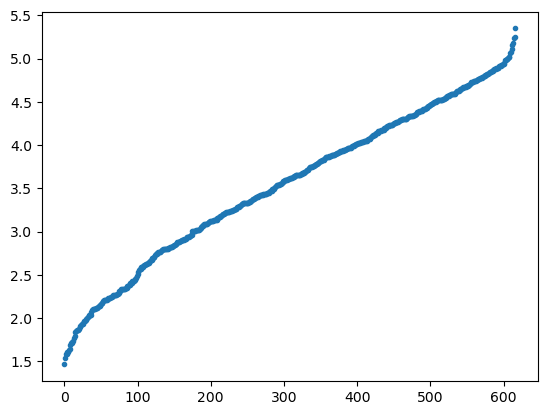

In [5]:
plt.plot(creep_df['Log_Creep_Life'], '.')

In [6]:
features = creep_df.iloc[:, 0:21]
targets = creep_df.iloc[:, 21]
features

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,Al,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.015,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.018,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.011,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.021,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.027,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538


In [7]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
Pearson CC: 0.994868596163743
R2 score: 0.9895821939712738
RMSE: 0.0909550133624889
MAE: 0.06298785600694803
Coverage: 93.5483870967742
Interval Width: 0.32128904704400973
Composite Metric: 1.4797284421777315


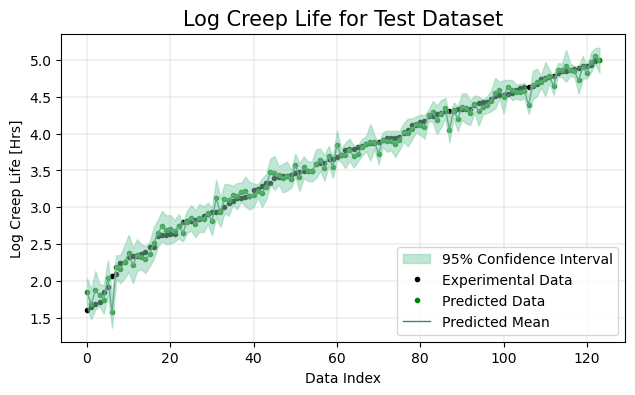

********************
Run # 1 Fold # 2
Pearson CC: 0.9952450717135871
R2 score: 0.9898432377537855
RMSE: 0.0934775170169193
MAE: 0.0631851248820238
Coverage: 91.12903225806454
Interval Width: 0.3426425797831536
Composite Metric: 1.413091013387083


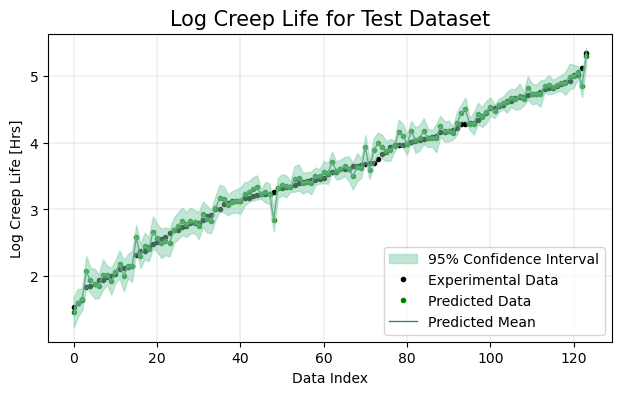

********************
Run # 1 Fold # 3
Pearson CC: 0.9954409387261393
R2 score: 0.9906479237191002
RMSE: 0.09083748386971094
MAE: 0.068514843636035
Coverage: 93.49593495934955
Interval Width: 0.3109490580562646
Composite Metric: 1.5052097270642202


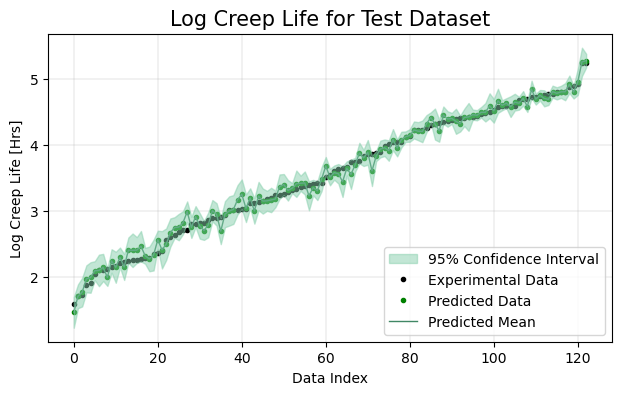

********************
Run # 1 Fold # 4
Pearson CC: 0.993307243972105
R2 score: 0.986497418782201
RMSE: 0.10020570540671485
MAE: 0.0673385255991548
Coverage: 93.49593495934955
Interval Width: 0.31798121379233546
Composite Metric: 1.4874294804458497


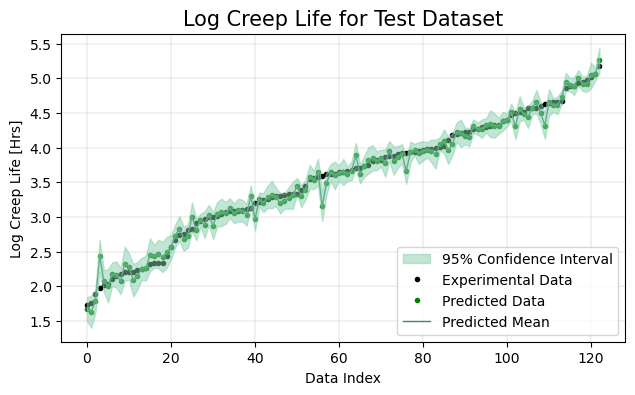

********************
Run # 1 Fold # 5
Pearson CC: 0.9957833781044889
R2 score: 0.9915297364928173
RMSE: 0.0809175898021867
MAE: 0.059692026475222947
Coverage: 97.56097560975606
Interval Width: 0.3418044630205639
Composite Metric: 1.463119650869875


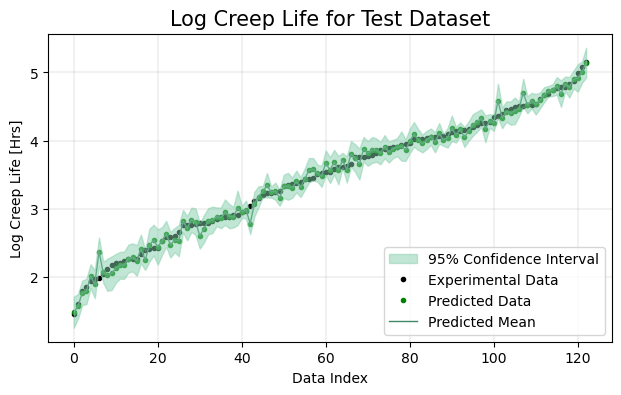

********************


In [8]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)


            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]
            ## Uncertainty quantification plot
            y_pred = y_pred_test
            y_std = y_pred_unc_test
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
            plt.show()
            print(20*'*')

In [9]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.994869,0.989582,0.090955,0.062988,93.548387
1,0.995245,0.989843,0.093478,0.063185,91.129032
2,0.995441,0.990648,0.090837,0.068515,93.495935
3,0.993307,0.986497,0.100206,0.067339,93.495935
4,0.995783,0.991530,0.080918,0.059692,97.560976


In [10]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.994929,0.000863,0.98962,0.001703,0.091279,0.0062,0.064344,0.0032,93.846053,2.074446


In [11]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,93.548387,0.321289,1.479728
1,91.129032,0.342643,1.413091
2,93.495935,0.310949,1.505210
3,93.495935,0.317981,1.487429
4,97.560976,0.341804,1.463120


In [12]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,93.846053,2.074446,0.326933,0.012926,1.469716,0.031381
